# Generating ERA5 forcing for Wflow.jl

With eWaterCycle we can generate forcing data for Wflow.jl, based on the ERA5 reanalysis product.

Do note that this data needs to be downloaded & ESMValTool has to be configured to be able to find the files.
For more info see the [ewatercycle infra guide](https://github.com/eWaterCycle/infra/blob/main/README.md).

In [1]:
from pathlib import Path
import numpy as np
from ewatercycle_wflowjl.forcing.forcing import WflowJlForcing
from ewatercycle_wflowjl.model import WflowJl
from ewatercycle.base.parameter_set import ParameterSet

parameters_humber = ParameterSet(
    name="humber",
    directory=Path("/home/bart/wflow_humber"),
    target_model="WflowJl",
    config="wflow_sbm.toml"   
)

hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).
/home/bart/micromamba/envs/ewatercycle/lib/python3.10/site-packages/esmvalcore/experimental/_warnings.py:13: UserWarning: 
  Thank you for trying out the new ESMValCore API.
  Note that this API is experimental and may be subject to change.
  More info: https://github.com/ESMValGroup/ESMValCore/issues/498


## Generating forcing
Using the WflowJlForcing class we can generate new forcing for a specific catchment.

The shape file and Wflow DEM of the catchment are required.

In [2]:
wflow_forcing = WflowJlForcing.generate(
    dataset="ERA5",
    start_time="1990-01-01T00:00:00Z",
    end_time="1990-12-31T00:00:00Z",
    shape="/home/bart/Documents/wflow_humber/shp/humber_catchment.shp",
    dem_file="/home/bart/Documents/wflow_humber/staticmaps.nc",
)

Now the model can be set up with the parameterset and the newly generated forcing:

In [3]:
model = WflowJl(
    parameter_set=parameters_humber,
    forcing=wflow_forcing
)

cfg_file,_ = model.setup()

In [4]:
model.initialize(cfg_file)

[ Info: Initialize model variables for model type `sbm`.
[ Info: Cyclic parameters are provided by `/home/bart/wflow_humber/staticmaps.nc`.
[ Info: Forcing parameters are provided by `/home/bart/esmvaltool_output/ewcrepmp232oh2_20231027_143032/work/diagnostic/script/wflow_ERA5_humber_catchment_1990_1990.nc`.
[ Info: Set `vertical.precipitation` using NetCDF variable `precip` as forcing parameter.
[ Info: Set `vertical.temperature` using NetCDF variable `temp` as forcing parameter.
[ Info: Set `vertical.potential_evaporation` using NetCDF variable `pet` as forcing parameter.
[ Info: Set `vertical.leaf_area_index` using NetCDF variable `LAI` as cyclic parameter.
┌ Info: General model settings
│   reservoirs = true
│   lakes = false
│   snow = true
│   masswasting = true
└   glacier = false
[ Info: Set `subcatchment` using NetCDF variable `wflow_subcatch`.
[ Info: Set `river_location` using NetCDF variable `wflow_river`.
[ Info: Set `lateral.river.width` using NetCDF variable `wflow_river

To get some data, we can extract discharge two locations in the river network:

In [5]:
#      Location A, Location B.
lats = [53.274166, 53.765833,]
lons = [-0.761666, -0.986666,]

ntimesteps = int(model._bmi.get_end_time() / model._bmi.get_time_step()) - 1
q_locs = np.zeros((ntimesteps, 2,))
dtimes = []
for tstep in range(q_locs.shape[0]):
    model.update()
    q_locs[tstep] = model.get_value_at_coords("lateral.river.q_av", lats, lons)
    dtimes.append(model.time_as_datetime)

The resulting discharges look like the following image:

Text(0, 0.5, 'discharge [m3/s]')

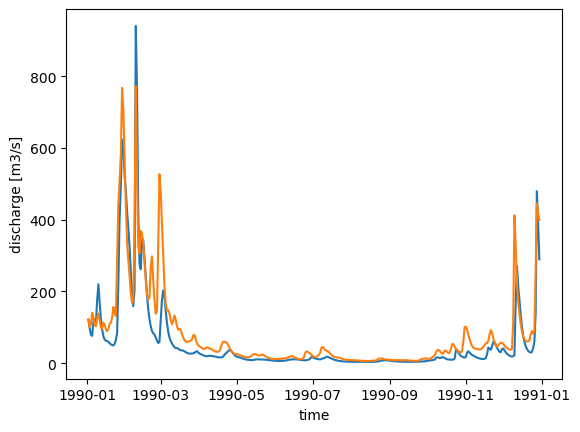

In [6]:
import matplotlib.pyplot as plt
plt.plot(dtimes, q_locs[:, 0])
plt.plot(dtimes, q_locs[:, 1])
plt.xlabel("time")
plt.ylabel("discharge [m3/s]")